Here's some guide for this assessment:

1. Obtain the dataset file from the assessment instruction.
2. The dataset file is split into image and label folder. You need to find a way to read all the images and labels as numpy array.
3. The most straight forward way to read an image is to use OpenCV (cv2.imread())
4. Resize your image and label into width and height of (128,128)
5. For the label, it is in the form of binary mask image (black and white image), you need to find a way to read the mask image, then process the value of the pixels so that they become class label ([0,255] --> [0,1])
6. You can perform train test split on the numpy arrays for the images and labels using scikit learn.
7. You can convert the numpy array into tensorflow tensors using this method: tf.data.Dataset.from_tensor_slices()
8. You can combine the images and labels together to form a single dataset using this method: tf.data.Dataset.zip(), do this for both train and test data.
9. Perform the same dataset preparation step as the demo.
10. Construct a UNet, then train this model so that it reaches at least 80% accuracy for both train and test.
11. Deploy the model and make prediction

(Hint: You can refer to the image segmentation tutorial from tensorflow)

In [1]:
#1. Import packages
import tensorflow as tf
import keras
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob, os
from keras import layers,losses,callbacks,activations,regularizers,metrics,applications,optimizers

In [2]:
filepath = "C:\\Users\\suhaimi\\Documents\\MAFA\\Capstone_Project\\Capstone_4\\dataset"
images = []
masks = []

In [3]:
#2. Load images
image_path = os.path.join(filepath,'inputs')
for img in os.listdir(image_path):
    #Get the full path of the image file
    full_path = os.path.join(image_path,img)
    #Read the image file based on the full path
    img_np = cv2.imread(full_path)
    #Convert the image from bgr to rgb
    img_np = cv2.cvtColor(img_np,cv2.COLOR_BGR2RGB)
    #Resize the image into 128x128
    img_np = cv2.resize(img_np,(128,128))
    #Place the image into the empty list
    images.append(img_np)

#3. Load masks
mask_path = os.path.join(filepath,'masks')
for mask in os.listdir(mask_path):
    #Get the full path of the mask file
    full_path = os.path.join(mask_path,mask)
    #Read the mask file as a grayscale image
    mask_np = cv2.imread(full_path,cv2.IMREAD_GRAYSCALE)
    #Resize the image into 128x128
    mask_np = cv2.resize(mask_np,(128,128))
    #Place the mask into the empty list
    masks.append(mask_np)

In [4]:
#4. Convert the list of np array into a full np array
images_np = np.array(images)
masks_np = np.array(masks)

In [5]:
#5. Data preprocessing
#5.1. Expand the mask dimension to include the channel axis
masks_np_exp = np.expand_dims(masks_np,axis=-1)
#5.2. Convert the mask value into just 0 and 1
converted_masks_np = np.round(masks_np_exp/255)
#5.3. Normalize the images pixel value
normalized_images_np = images_np/255.0

In [6]:
#6. Perform train test split
from sklearn.model_selection import train_test_split
SEED = 12345
X_train,X_test,y_train,y_test = train_test_split(normalized_images_np,converted_masks_np,shuffle=True,random_state=SEED)

In [7]:
#7. Convert the numpy array into tensorflow tensors
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)
y_test_tensor = tf.data.Dataset.from_tensor_slices(y_test)

In [8]:
#8. Combine features and labels together to form a zip dataset
train = tf.data.Dataset.zip((X_train_tensor,y_train_tensor))
test = tf.data.Dataset.zip((X_test_tensor,y_test_tensor))

In [9]:
# 9. Create a custom class for augmentation
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [10]:
# Prepare the dataset
TRAIN_LENGTH = 670
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_batches = (
    train
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test.batch(BATCH_SIZE)

In [11]:
# 10. Create a function to visualize the image, label and prediction
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

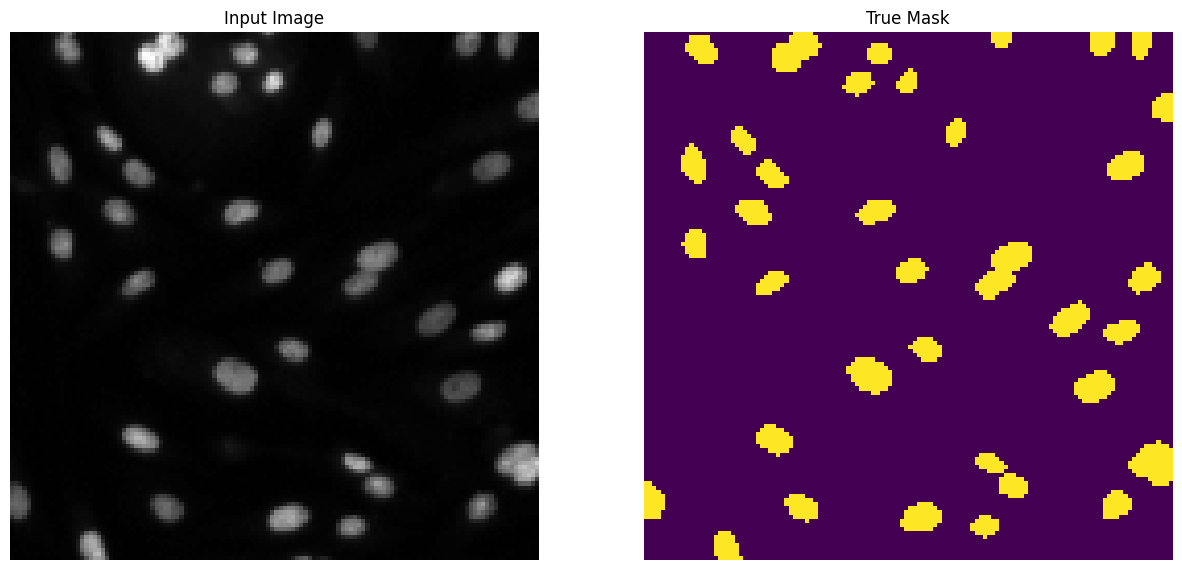

(128, 128, 3)
(128, 128, 1)


In [12]:
# Test out the function to display an example
for images,labels in train_batches.take(1):
    sample_image,sample_mask = images[0],labels[0]
    display([sample_image,sample_mask])
    print(sample_image.shape)
    print(sample_mask.shape)

## Unet

In [13]:
# 11. Model development
# (A) Get the pretrained model as feature extractor using keras.applications
base_model = applications.MobileNetV2(input_shape=sample_image.shape,include_top=False,alpha=0.5)
base_model.summary()

Model: "mobilenetv2_0.50_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        432 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64, 8) │        128 │ expanded_conv_de… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64, 8) │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │        768 │ block_1_depthwis

 Total params: 706,224 (2.69 MB)

 Trainable params: 687,680 (2.62 MB)

 Non-trainable params: 18,544 (72.44 KB)

In [14]:
# 12. Properly create the downsampling path of the model
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = keras.Model(inputs=base_model.input, outputs=base_model_outputs)
# Freeze the feature extractor
down_stack.trainable = False

In [15]:
# Create the upsampling layers
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]
up_stack[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
# 13. Create a function to construct the Unet model
def unet_model(output_channels:int):
    # Use functional API to build the model
    # (A) Start with the input
    inputs = keras.Input(shape=sample_image.shape)
    # (B) Followed by the feature extractor
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    # (C) Build the upsampling path by concatenate with the outputs from feature extractor, along with using the upsampling layers
    for up, skip in zip(up_stack, skips):
        # Perform the upsampling first
        x = up(x)
        # Concatenate the output from the upsampling layer with the previous pooling layer
        concat = layers.Concatenate()
        x = concat([x,skip])
    # (D) Perform one last upsampling to restore back to original resolution
    last = layers.Conv2DTranspose(filters=output_channels,kernel_size=3,strides=2,padding='same')   # 64x64 --> 128x128
    x = last(x)
    model = keras.Model(inputs=inputs,outputs=x)
    return model

In [17]:
# 14. Use the function to create the Unet
model = unet_model(output_channels=3)
model.summary()
keras.utils.plot_model(model,to_file=model.png)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 64, 64,   │    495,664 │ input_layer_1[0]… │
│ (Functional)        │ 48), (None, 32,   │            │                   │
│                     │ 32, 96), (None,   │            │                   │
│                     │ 16, 16, 96),      │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 288), (None, 4,   │            │                   │
│                     │ 4, 160)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8, 8, 512) │    739,328 │ functional[0][4]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 800) │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 16, 16,    │  1,844,224 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 352)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    406,016 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 224)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64, 64,    │    129,280 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 112)              │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 128, 128,  │      3,027 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,617,539 (13.80 MB)

 Trainable params: 3,119,955 (11.90 MB)

 Non-trainable params: 497,584 (1.90 MB)

AttributeError: 'Functional' object has no attribute 'png'

In [ ]:
# 15. Compile the model
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',loss=loss,metrics=['accuracy'])

In [ ]:
# 16. Create a custom callback to display result in the middle of the training.
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
class DisplayCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
# Prepare for the training
import os,datetime
logpath = os.path.join("seg_log",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = callbacks.TensorBoard(log_dir=logpath)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


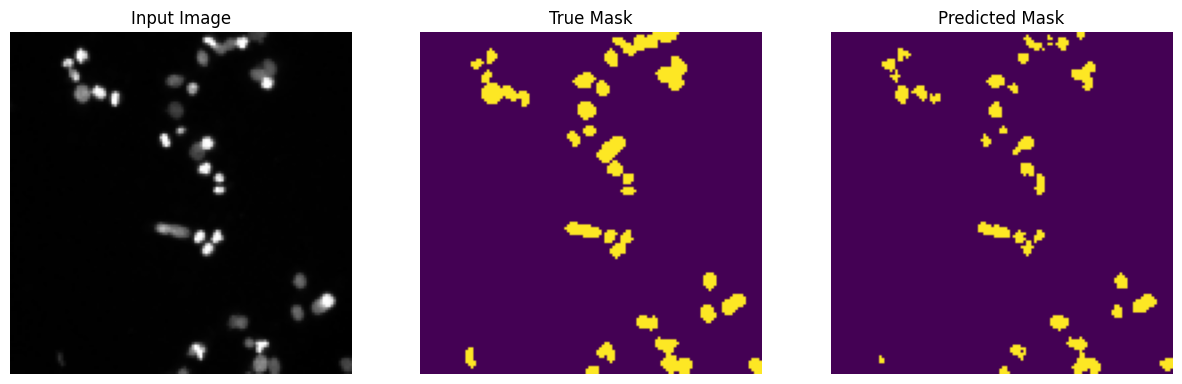


Sample Prediction after epoch 40

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 736ms/step - accuracy: 0.9710 - loss: 0.0716 - val_accuracy: 0.9599 - val_loss: 0.0952


In [ ]:
# 17. Model training
es = callbacks.EarlyStopping(patience=7,verbose=1)
EPOCHS = 40
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 670 // BATCH_SIZE // VAL_SUBSPLITS
model_history = model.fit(
    x=train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_batches,
    validation_steps=VALIDATION_STEPS,
    callbacks=[tb,es,DisplayCallback()]
)

In [ ]:
# 18. Evaluate the model
print(model.evaluate(test_batches))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.9599 - loss: 0.0952
[0.09223679453134537, 0.9612757563591003]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


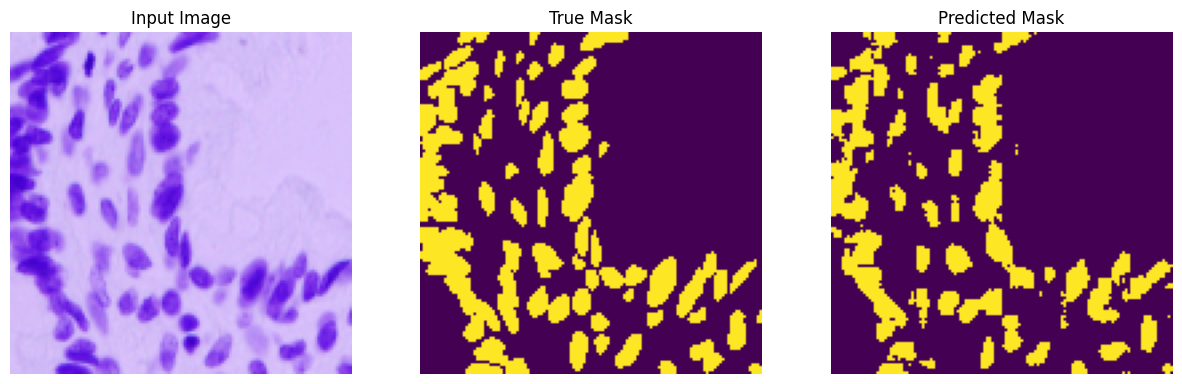

In [ ]:
# 19. Use the model to make prediction
for test_img,test_label in test_batches.take(1):
    predictions = model.predict(test_img)
    predictions = np.argmax(predictions,axis=-1)
    predictions = np.expand_dims(predictions,axis=-1)

# Take a data out to plot
display([test_img[32],test_label[32],predictions[32]])

In [ ]:
#Save the model
#model.save("model/model.keras")